In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np

/Users/quentinfisch/Documents/EPITA/ING2/SCIA/S8/NLP1/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("imdb")
dataset

Found cached dataset imdb (/Users/quentinfisch/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
100%|██████████| 3/3 [00:00<00:00, 128.00it/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

## Features

### Preprocessing

In [3]:
from string import punctuation
import re

def preprocess(df: pd.DataFrame) -> pd.DataFrame :
    """
    Preprocess the dataset by lowercasing the text and removing the punctuation manually

    Parameters
    ----------
    df : pd.DataFrame
        The dataset to preprocess

    Returns
    -------
    pd.DataFrame
        The preprocessed dataset
    """
    # First lower the case
    df["document"] = df["document"].apply(lambda x: x.lower())
    # Replace the punctuation with spaces. We keep the ' - that may give revelant informations
    # Replace HTML tag <br />
    punctuation_to_remove = '|'.join(map(re.escape, sorted(list(filter(lambda p: p != "'" and p != '-' and p != "!", punctuation)), reverse=True)))
    print(f"Deleting all these punctuation: {punctuation_to_remove}")
    df["document"] = df["document"].apply(lambda x: re.sub(punctuation_to_remove, " ", x.replace('<br />', "")))
    # Remove the multiple spaces
    df["document"] = df["document"].apply(lambda x: re.sub(' +', ' ', x))
    # Remove the leading and trailing whitespaces
    df["document"] = df["document"].apply(lambda x: x.strip())
    return df

In [4]:
train_raw = pd.DataFrame(dataset["train"], columns=["text", "label"]).rename(columns={"text": "document", "label": "class"})
preprocessed_train = preprocess(train_raw)
test_raw = pd.DataFrame(dataset["test"], columns=["text", "label"]).rename(columns={"text": "document", "label": "class"})
preprocessed_test = preprocess(test_raw)
preprocessed_train.head(), preprocessed_test.head()

Deleting all these punctuation: \~|\}|\||\{|`|_|\^|\]|\\|\[|@|\?|>|=|<|;|:|/|\.|,|\+|\*|\)|\(|\&|%|\$|\#|"
Deleting all these punctuation: \~|\}|\||\{|`|_|\^|\]|\\|\[|@|\?|>|=|<|;|:|/|\.|,|\+|\*|\)|\(|\&|%|\$|\#|"


(                                            document  class
 0  i rented i am curious-yellow from my video sto...      0
 1  i am curious yellow is a risible and pretentio...      0
 2  if only to avoid making this type of film in t...      0
 3  this film was probably inspired by godard's ma...      0
 4  oh brother after hearing about this ridiculous...      0,
                                             document  class
 0  i love sci-fi and am willing to put up with a ...      0
 1  worth the entertainment value of a rental espe...      0
 2  its a totally average film with a few semi-alr...      0
 3  star rating saturday night friday night friday...      0
 4  first off let me say if you haven't enjoyed a ...      0)

Load lexicon and keep only interesting tokens (one above the treshold)

In [5]:
threshold = 1
lexicon = pd.read_csv("vader_lexicon.txt", sep="\t", names=['Token', "Score", "Std", "Vector"]).drop(columns=["Std", "Vector"]).set_index("Token")
lexicon = lexicon[(lexicon["Score"] <= -threshold) | (lexicon["Score"] >= threshold)]
lexicon

,Score
Token,
$:,-1.5
%-),-1.5
( '}{' ),1.6
('-:,2.2
(':,2.3
...,...
|^:,-1.1
||-:,-2.3
}:,-2.1


Generate the following features:
- 1 if "no" appears in the document, 0 otherwise.
- The count of first and second pronouns in the document.
- 1 if "!" is in the document, 0 otherwise.
- Log(word count in the document).
- Number of words in the document which are in the positive lexicon.
- Number of words in the document which are in the negative lexicon.
- [Bonus] Add another feature of your choice.

In [6]:
def is_in_lexicon(word: str, positive: bool):
    try:
        score = lexicon.at[word, "Score"].item()
        return score >= threshold if positive else score <= -threshold
    except:
        return False

def generate_features(dataset: pd.DataFrame) -> pd.DataFrame :
    """
    Generate the features for the dataset

    Parameters
    ----------
    dataset : pd.DataFrame
        The dataset to generate the features for

    Returns
    -------
    pd.DataFrame
        The dataset with the features
    """
    dataset["no"] = dataset["document"].apply(lambda x: 1 if "no" in x.split(" ") else 0)
    dataset["pronouns"] = dataset["document"].apply(lambda x: x.split(" ")).apply(lambda x: x.count("i") + x.count("we") + x.count("you"))
    dataset["exclamation"] = dataset["document"].apply(lambda x: 1 if "!" in x else 0)
    dataset["log_word_count"] = dataset["document"].apply(lambda x: np.log(len(x.split(" "))))
    dataset["positive_lexicon"] = dataset["document"].apply(lambda x: len(list(filter(lambda w: is_in_lexicon(w, True), x.split(" ")))))
    dataset["negative_lexicon"] = dataset["document"].apply(lambda x: len(list(filter(lambda w: is_in_lexicon(w, False), x.split(" ")))))

    # add feature vector column
    dataset["feature_vector"] = dataset.apply(lambda x: [x["no"], x["pronouns"], x["exclamation"], x["log_word_count"], x["positive_lexicon"], x["negative_lexicon"]], axis=1)
    # drop the other columns
    dataset = dataset.drop(columns=["no", "pronouns", "exclamation", "log_word_count", "positive_lexicon", "negative_lexicon"])

    return dataset

In [7]:
reduced_train = preprocessed_train.iloc[::10].copy()
reduced_train = generate_features(reduced_train)
reduced_train

,document,class,feature_vector
0,i rented i am curious-yellow from my video sto...,0,"[1, 7, 0, 5.655991810819852, 7, 6]"
10,it was great to see some of my favorite stars ...,0,"[1, 7, 0, 5.552959584921617, 14, 4]"
20,if the crew behind zombie chronicles ever read...,0,"[1, 7, 0, 5.135798437050262, 9, 2]"
30,i have not seen many low budget films i must a...,0,"[0, 6, 0, 5.123963979403259, 8, 7]"
40,i have read all of the love come softly books ...,0,"[0, 5, 0, 4.912654885736052, 5, 3]"
...,...,...,...
24950,i definitely recommend reading the book prior ...,1,"[0, 5, 1, 5.634789603169249, 14, 3]"
24960,i used to watch this show when i was a little ...,1,"[0, 12, 0, 4.990432586778736, 9, 0]"
24970,i've seen this movie and i must say i'm very i...,1,"[0, 11, 0, 4.919980925828125, 13, 2]"
24980,i was pleased to see that she had black hair! ...,1,"[0, 8, 1, 5.003946305945459, 9, 3]"


In [14]:
reduced_test = preprocessed_test.iloc[::10].copy()

reduced_test = generate_features(reduced_test)
reduced_test

,document,class,feature_vector
0,i love sci-fi and am willing to put up with a ...,0,"[0, 5, 1, 5.62040086571715, 9, 8]"
10,this flick is a waste of time i expect from an...,0,"[1, 1, 0, 4.948759890378168, 3, 12]"
20,low budget horror movie if you don't raise yo...,0,"[0, 6, 1, 5.225746673713202, 10, 7]"
30,lowe returns to the nest after yet another f...,0,"[0, 4, 1, 5.459585514144159, 8, 9]"
40,i can't believe the high marks people have giv...,0,"[0, 6, 1, 5.6240175061873385, 8, 9]"
...,...,...,...
24950,especially by lambert this is the essential...,1,"[0, 8, 0, 5.10594547390058, 8, 3]"
24960,watch it with an open mind it is very differe...,1,"[0, 1, 0, 4.02535169073515, 4, 0]"
24970,slipknot is a heavy metal band from the great ...,1,"[0, 8, 0, 5.117993812416755, 6, 1]"
24980,this film is just plain lovely it's funny as ...,1,"[0, 3, 1, 4.912654885736052, 5, 2]"


In [7]:
preprocessed_train = generate_features(preprocessed_train)
print("Train set generated")
preprocessed_test = generate_features(preprocessed_test)
print("Test set generated")

Train set generated
Test set generated


In [3]:
from abc import ABC, abstractmethod
from string import punctuation
import re

class DatasetManager(ABC):
    """
    Abstract class to manage the dataset
    
    Methods
    -------
    _raw_dataset(split: str) -> pd.DataFrame
        Return the raw dataset as a pandas dataframe
    preprocess(df: pd.DataFrame) -> pd.DataFrame
        Preprocess the dataset by lowercasing the text and removing the punctuation manually
    """
    @abstractmethod
    def _raw_dataset(self, split: str) -> pd.DataFrame:
        raise NotImplementedError()
    
    @abstractmethod
    def preprocess(self, df: pd.DataFrame) -> pd.DataFrame :
        raise NotImplementedError()
    
    @abstractmethod
    def generate_features(self, dataset) :
        raise NotImplementedError()


class IMDBDataset(DatasetManager):
    """
    Class to manage the IMDB dataset using Pandas

    Parameters
    ----------
    dataset : dict
        The dataset to manage

    Attributes
    ----------
    dataset : dict
        The dataset to manage
    train_raw : pd.DataFrame
        The raw train dataset
    test_raw : pd.DataFrame
        The raw test dataset
    train : pd.DataFrame
        The preprocessed train dataset
    test : pd.DataFrame 
        The preprocessed test dataset
    lexicon : pd.DataFrame
        The lexicon used to generate the features
    """
    def __init__(self, dataset: dict):
        self.dataset = dataset
        self.train_raw = self._raw_dataset("train")
        self.test_raw = self._raw_dataset("test")
        self.train = self.preprocess(self.train_raw)
        self.test = self.preprocess(self.test_raw)
    
    def _raw_dataset(self, split: str) -> pd.DataFrame:
        """
        Return the raw dataset as a pandas dataframe

        Parameters
        ----------
        split : str
            The split of the dataset to return

        Returns
        -------
        pd.DataFrame
            The raw dataset as a pandas dataframe
        """
        return pd.DataFrame(dataset[split], columns=["text", "label"]).rename(columns={"text": "document", "label": "class"})
    
    def preprocess(self, df: pd.DataFrame) -> pd.DataFrame :
        """
        Preprocess the dataset by lowercasing the text and removing the punctuation manually

        Parameters
        ----------
        df : pd.DataFrame
            The dataset to preprocess

        Returns
        -------
        pd.DataFrame
            The preprocessed dataset
        """
        # First lower the case
        df["document"] = df["document"].apply(lambda x: x.lower())
        # Replace the punctuation with spaces. We keep the ' - that may give revelant informations
        # Replace HTML tag <br />
        punctuation_to_remove = '|'.join(map(re.escape, sorted(list(filter(lambda p: p != "'" and p != '-' and p != "!", punctuation)), reverse=True)))
        print(f"Deleting all these punctuation: {punctuation_to_remove}")
        df["document"] = df["document"].apply(lambda x: re.sub(punctuation_to_remove, " ", x.replace('<br />', "")))
        # Remove the multiple spaces
        df["document"] = df["document"].apply(lambda x: re.sub(' +', ' ', x))
        # Remove the leading and trailing whitespaces
        df["document"] = df["document"].apply(lambda x: x.strip())
        return df

    def add_lexicon(self, lexicon: pd.DataFrame, threshold: int = 1) -> None:
        """
        Add the lexicon to the dataset

        Parameters
        ----------
        lexicon : pd.DataFrame
            The lexicon to add
        threshold : int, optional
            The threshold to use to add the lexicon, by default 1

        Returns
        -------
        None
        """
        self.lexicon = lexicon[(lexicon["Score"] <= -threshold) | (lexicon["Score"] >= threshold)]

    def is_in_lexicon(self, word: str, positive: bool):
        """
        Check if the word is in the lexicon

        Parameters
        ----------
        word : str
            The word to check
        positive : bool
            If the word should be positive or negative

        Returns
        -------
        bool
            True if the word is in the lexicon, False otherwise
        """
        try:
            score = lexicon.at[word, "Score"].item()
            return score >= threshold if positive else score <= -threshold
        except:
            return False

    def generate_features(self, df: pd.DataFrame) -> None :
        """
        Generate the features for the dataset

        Parameters
        ----------
        df : pd.DataFrame
            The dataset to generate the features for
        """
        df["no"] = df["document"].apply(lambda x: 1 if "no" in x.split(" ") else 0)
        df["pronouns"] = df["document"].apply(lambda x: x.split(" ")).apply(lambda x: x.count("i") + x.count("we") + x.count("you"))
        df["exclamation"] = df["document"].apply(lambda x: 1 if "!" in x else 0)
        df["log_word_count"] = df["document"].apply(lambda x: np.log(len(x.split(" "))))
        df["positive_lexicon"] = df["document"].apply(lambda x: len(list(filter(lambda w: is_in_lexicon(w, True), x.split(" ")))))
        df["negative_lexicon"] = df["document"].apply(lambda x: len(list(filter(lambda w: is_in_lexicon(w, False), x.split(" ")))))

        # add feature vector column
        df["feature_vector"] = df.apply(lambda x: [x["no"], x["pronouns"], x["exclamation"], x["log_word_count"], x["positive_lexicon"], x["negative_lexicon"]], axis=1)
        # drop the other columns
        df = df.drop(columns=["no", "pronouns", "exclamation", "log_word_count", "positive_lexicon", "negative_lexicon"])
        return df

In [18]:
imdb_dataset = IMDBDataset(dataset)
lexicon = pd.read_csv("vader_lexicon.txt", sep="\t", names=['Token', "Score", "Std", "Vector"]).drop(columns=["Std", "Vector"]).set_index("Token")
imdb_dataset.add_lexicon(lexicon, threshold=1)
imdb_dataset.train = imdb_dataset.generate_features(imdb_dataset.train.copy())
imdb_dataset.test = imdb_dataset.generate_features(imdb_dataset.test.copy())
imdb_dataset.train.head()

Deleting all these punctuation: \~|\}|\||\{|`|_|\^|\]|\\|\[|@|\?|>|=|<|;|:|/|\.|,|\+|\*|\)|\(|\&|%|\$|\#|"
Deleting all these punctuation: \~|\}|\||\{|`|_|\^|\]|\\|\[|@|\?|>|=|<|;|:|/|\.|,|\+|\*|\)|\(|\&|%|\$|\#|"


,document,class,feature_vector
0,i rented i am curious-yellow from my video sto...,0,"[1, 7, 0, 5.655991810819852, 7, 6]"
1,i am curious yellow is a risible and pretentio...,0,"[1, 2, 0, 5.365976015021851, 5, 4]"
2,if only to avoid making this type of film in t...,0,"[1, 0, 0, 4.48863636973214, 3, 3]"
3,this film was probably inspired by godard's ma...,0,"[0, 3, 0, 4.770684624465665, 5, 5]"
4,oh brother after hearing about this ridiculous...,0,"[0, 10, 1, 5.733341276897746, 4, 11]"


## Logistic regression classifier

In [4]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [5]:
class LinearRegression(nn.Module):
    """A linear regression implementation"""

    def __init__(self, input_dim: int, nb_classes: int) -> None:
        """
        Args:
            input_dim: the dimension of the input features.
            nb_classes: the number of classes to predict.
        """
        super().__init__()
        self.linear = nn.Linear(input_dim, nb_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: the input tensor.
        Returns:
            The output of the linear layer.
        """
        return self.linear(x)

In [23]:
model = LinearRegression(6, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.5)

Split the data into training and test sets.

In [25]:
features_train = imdb_dataset.train["feature_vector"]
# convert to numpy array 2d
features_train = np.array(features_train.to_list())
labels_train = imdb_dataset.train["class"].to_numpy()

features_train = torch.tensor(features_train, dtype=torch.float32)
labels_train = torch.tensor(labels_train, dtype=torch.float32).reshape(-1, 1)

X_train, X_valid, y_train, y_valid = train_test_split(
    features_train,
    labels_train,
    test_size=0.15,
    stratify=labels_train,
    random_state=42,
)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

(torch.Size([21250, 6]),
 torch.Size([3750, 6]),
 torch.Size([21250, 1]),
 torch.Size([3750, 1]))

In [26]:
# Let's do the same feature engineering for the test set
features_test = imdb_dataset.test["feature_vector"]
features_test = np.array(features_test.to_list())
X_test = torch.tensor(features_test, dtype=torch.float32)

labels_test = imdb_dataset.test["class"].to_numpy()
y_test = torch.tensor(labels_test, dtype=torch.float32).reshape(-1, 1)

X_test.shape, y_test.shape

(torch.Size([25000, 6]), torch.Size([25000, 1]))

In [27]:
%%time

n_epochs = 1000

# Keeping an eye on the losses
train_losses = []
test_losses = []

# Training loop
for epoch in range(n_epochs):
    # Setting all gradients to zero.
    optimizer.zero_grad()

    # Sending the whole training set through the model.
    predictions = model(X_train)
    # Computing the loss.
    loss = criterion(predictions, y_train)
    train_losses.append(loss.item())
    if epoch % 100 == 0:
        print(loss)
    # Computing the gradients and gradient descent.
    loss.backward()
    optimizer.step()

    # When computing the validation loss, we do not want to update the weights.
    # torch.no_grad tells PyTorch to not save the necessary data used for
    # gradient descent.
    with torch.no_grad():
        predictions = model(X_valid)
        loss = criterion(predictions, y_valid)
        test_losses.append(loss)

tensor(2.1841, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5853, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5840, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5839, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5838, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5838, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5838, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5838, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5838, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5838, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
CPU times: user 755 ms, sys: 233 ms, total: 988 ms
Wall time: 768 ms


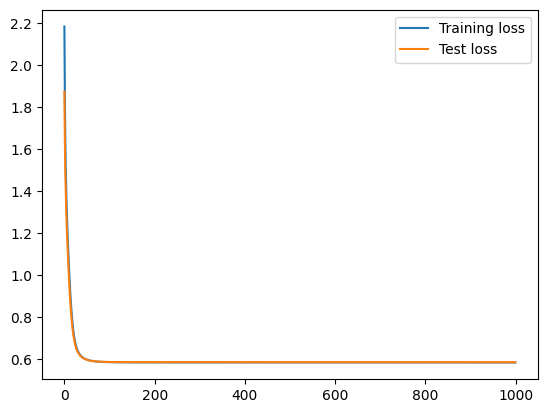

In [28]:
plt.plot(np.arange(len(train_losses)), train_losses, label="Training loss")
plt.plot(np.arange(len(test_losses)), test_losses, label="Test loss")
plt.legend()

In [29]:
with torch.no_grad():
    p_train = torch.sigmoid(model(X_train))
    p_train = np.round(p_train.numpy())
    training_accuracy = np.mean(p_train == y_train.numpy())
    p_valid = torch.sigmoid(model(X_valid))
    p_valid = np.round(p_valid.numpy())
    valid_accuracy = np.mean(p_valid == y_valid.numpy())
    p_test = torch.sigmoid(model(X_test))
    p_test = np.round(p_test.numpy())
    test_accuracy = np.mean(p_test == y_test.numpy())
print(training_accuracy, valid_accuracy, test_accuracy)

0.7149176470588235 0.7034666666666667 0.71348


In [30]:
# Look at the weights of your classifier. Which features seems to play most for both classes ?

# Let's look at the weights of the linear layer
weights = model.linear.weight.detach().numpy()
print(weights)
print(np.argmax(weights))

[[-0.03016669 -0.04087529 -0.00730748 -0.01868127  0.12871487 -0.1512581 ]]
4


The feature playing the most important role in the classification is the number of words in the document which are in the positive lexicon. This is not surprising as the positive lexicon contains words such as "good", "great", "excellent", etc. which are very indicative of a positive review.

In [31]:
# Take two wrongly classified samples in the test set and try explaining why the model was wrong.

# Let's look at the wrongly classified samples
wrongly_classified = np.where(p_test != y_test.numpy())[0]
print(wrongly_classified)

# Let's look at the first wrongly classified sample
print(imdb_dataset.test.iloc[wrongly_classified[0]]["document"], imdb_dataset.test.iloc[wrongly_classified[0]], sep="\n")

# Let's look at the second wrongly classified sample
print(imdb_dataset.test.iloc[wrongly_classified[1]]["document"], imdb_dataset.test.iloc[wrongly_classified[1]], sep="\n")

[    4     6    11 ... 24991 24998 24999]
first off let me say if you haven't enjoyed a van damme movie since bloodsport you probably will not like this movie most of these movies may not have the best plots or best actors but i enjoy these kinds of movies for what they are this movie is much better than any of the movies the other action guys segal and dolph have thought about putting out the past few years van damme is good in the movie the movie is only worth watching to van damme fans it is not as good as wake of death which i highly recommend to anyone of likes van damme or in hell but in my opinion it's worth watching it has the same type of feel to it as nowhere to run good fun stuff!
document          first off let me say if you haven't enjoyed a ...
class                                                             0
feature_vector                  [0, 4, 1, 4.897839799950911, 12, 2]
Name: 4, dtype: object
isaac florentine has made some of the best western martial arts action m

These wrondly classified examples are mostly positive reviews which are classified as negative. This is surely because they are really hard to classify, mixing positive and negative parts. In the first one: 'if you haven't enjoyed a van damme movie since bloodsport you probably will not like this movie' is negative when read on its own, but positive when read in the context of the whole review. The second one also contains negative or mixed parts inside the whole review, which is very confusing for the classifier.

#### Cleaning and refactoring

Let's wrap the classifier inside a class to make it easier to use.

In [17]:
from typing import List

class ClassifierWrapper():
    random_state = 42

    def __init__(self, model: nn.Module, criterion, optimizer, dataset_manager: DatasetManager):
        """
        Args:
            model: the model to train.
            criterion: the loss function.
            optimizer: the optimizer.
            dataset_manager: the dataset manager.
        """
        self.model = model
        self.dataset_manager = dataset_manager
        self.criterion = criterion
        self.optimizer = optimizer
        self._extract_features()
        self.X_train, self.X_valid, self.y_train, self.y_valid = self._split_train_valid()
    

    def _extract_features(self):
        """
        Extracts the features and labels from the dataset manager
        """
        self.features_train = self.dataset_manager.train["feature_vector"]
        self.features_train = np.array(self.features_train.to_list()).astype(np.float32)
        self.features_train = torch.tensor(self.features_train, dtype=torch.float32)
        self.labels_train = self.dataset_manager.train["class"].to_numpy()
        self.labels_train = torch.tensor(self.labels_train, dtype=torch.float32).reshape(-1, 1)

        self.features_test = self.dataset_manager.test["feature_vector"]
        self.features_test = np.array(self.features_test.to_list()).astype(np.float32)
        self.features_test = torch.tensor(self.features_test, dtype=torch.float32)
        self.labels_test = self.dataset_manager.test["class"].to_numpy()
        self.labels_test = torch.tensor(self.labels_test, dtype=torch.float32).reshape(-1, 1)


    def _split_train_valid(self, test_size: float = 0.15) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Splits the training set into training and validation sets

        Parameters
        ----------
        test_size : float, optional
            The proportion of the training set to use for validation, by default 0.15

        Returns
        -------
        X_train, X_valid, y_train, y_valid : torch.Tensor
            The training and validation sets
        """
        X_train, X_valid, y_train, y_valid = train_test_split(
            self.features_train,
            self.labels_train,
            test_size=test_size,
            stratify=self.labels_train,
            random_state=self.random_state,
        )
        return X_train, X_valid, y_train, y_valid


    def fit(self, X: torch.Tensor = None, y: torch.Tensor = None, n_epochs: int = 1000) -> tuple[List[float], List[float]]:
        """
        Fits the model

        Parameters
        ----------
        X : torch.Tensor, optional
            The training set. If None, the training set from the dataset manager is used, by default None
        y : torch.Tensor, optional
            The labels of the training set. If None, the labels from the dataset manager are used, by default None
        n_epochs : int, optional
            The number of epochs to train for, by default 1000

        Returns
        -------
        train_losses, test_losses : List[float]
            The losses of the training and validation sets
        """
        if X is None:
            X = self.X_train
        if y is None:
            y = self.y_train

        train_losses = []
        test_losses = []
        for epoch in range(n_epochs):
            self.optimizer.zero_grad()
            predictions = self.model(X)
            loss = self.criterion(predictions, y)
            train_losses.append(loss.item())
            if epoch % 100 == 0:
                print(loss)
            loss.backward()
            self.optimizer.step()

            with torch.no_grad():
                predictions = self.model(self.X_valid)
                loss = self.criterion(predictions, self.y_valid)
                test_losses.append(loss)

        self.train_losses = train_losses
        self.test_losses = test_losses


    def plot_losses(self):
        """
        Plots the losses of the training and validation sets
        """
        plt.plot(np.arange(len(self.train_losses)), self.train_losses, label="Training loss")
        plt.plot(np.arange(len(self.test_losses)), self.test_losses, label="Test loss")
        plt.legend()
        plt.show()
    

    def predict(self, X: torch.Tensor) -> torch.Tensor:
        """
        Predicts the labels of the given data

        Parameters
        ----------
        X : torch.Tensor
            The data to predict

        Returns
        -------
        p : torch.Tensor
            The predictions
        """
        with torch.no_grad():
            p = torch.sigmoid(self.model(X))
            p = np.round(p.numpy())
            return p

In [44]:
# reinitialize the model
model = LinearRegression(6, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.5)

classifier = ClassifierWrapper(model, criterion, optimizer, imdb_dataset)
classifier.fit()

tensor(2.5599, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5868, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5832, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5833, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5834, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5836, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5836, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5837, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5837, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5837, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


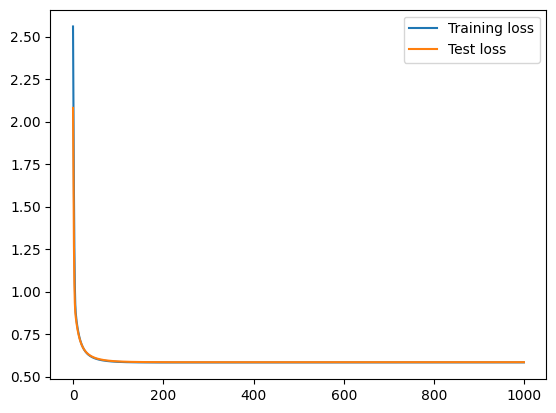

In [45]:
classifier.plot_losses()

In [46]:
p_train = classifier.predict(classifier.X_train)
training_accuracy = np.mean(p_train == classifier.y_train.numpy())
p_valid = classifier.predict(classifier.X_valid)
valid_accuracy = np.mean(p_valid == classifier.y_valid.numpy())
p_test = classifier.predict(classifier.features_test)
test_accuracy = np.mean(p_test == classifier.labels_test.numpy())
print(training_accuracy, valid_accuracy, test_accuracy)

0.7151058823529411 0.7029333333333333 0.71352


### Try using PySpark

It takes too much time to preprocess the data with Pandas, so we will use PySpark instead.
To do so, we will create a new DatasetManager class which will use PySpark to load the data and generate the features.

In a first place, we will detail separatly each step of the preprocessing, to make it easier to understand.

In [6]:
# let's use pyspark to preprocess the data
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.dataframe as pyspark_df
from pyspark.sql.functions import udf

spark = SparkSession.builder.getOrCreate()

23/04/03 09:03:17 WARN Utils: Your hostname, MacBook-Pro-de-FISCH.local resolves to a loopback address: 127.0.0.1; using 10.41.179.14 instead (on interface en0)
23/04/03 09:03:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/03 09:03:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/04/03 09:03:18 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Let's try to create a Spark dataframe from the dataset

In [7]:
# use 'dataset' variable and convert it to a spark dataframe
spark_df = spark.createDataFrame(dataset["train"], schema=["class", "document"])

# Let's look at the schema of the dataframe
spark_df.printSchema()

# Let's look at the first 10 rows of the dataframe
spark_df.show(10)

root
 |-- class: long (nullable = true)
 |-- document: string (nullable = true)



23/04/03 09:03:26 WARN TaskSetManager: Stage 0 contains a task of very large size (3893 KiB). The maximum recommended task size is 1000 KiB.


+-----+--------------------+
|class|            document|
+-----+--------------------+
|    0|I rented I AM CUR...|
|    0|"I Am Curious: Ye...|
|    0|If only to avoid ...|
|    0|This film was pro...|
|    0|Oh, brother...aft...|
|    0|I would put this ...|
|    0|Whoever wrote the...|
|    0|When I first saw ...|
|    0|Who are these "Th...|
|    0|This is said to b...|
+-----+--------------------+
only showing top 10 rows



Seems to be working as expected. Now, we need to do the same preprocessing as before, which means:
- lowercasing
- removing punctuation (except ' ! and -)
- remove extra spaces

In [8]:
def preprocess_spark(dataset: pd.DataFrame) -> pd.DataFrame :
    """
    Preprocess the dataset by lowercasing the text and removing the punctuation manually using spark

    Parameters
    ----------
    dataset : pd.DataFrame
        The dataset to preprocess

    Returns
    -------
    pd.DataFrame
        The preprocessed dataset
    """
    # First lower the case
    dataset = dataset.withColumn("document", F.lower(F.col("document")))
    # Replace the punctuation with spaces. We keep the ' - and ! that may give revelant informations
    # Replace HTML tag <br />
    dataset = dataset.withColumn("document", F.regexp_replace(F.col("document"), r"[^a-zA-Z0-9\s-!]", " "))
    dataset = dataset.withColumn("document", F.regexp_replace(F.col("document"), r"<br />", " "))
    # Remove the extra spaces
    dataset = dataset.withColumn("document", F.regexp_replace(F.col("document"), r"\s+", " "))
    return dataset

In [9]:
preprocessed_train_spark = preprocess_spark(spark_df)
preprocessed_train_spark.show(10)

preprocessed_test_spark = preprocess_spark(spark.createDataFrame(dataset["test"], schema=["class", "document"]))
preprocessed_test_spark.show(10)

23/04/03 09:03:35 WARN TaskSetManager: Stage 1 contains a task of very large size (3893 KiB). The maximum recommended task size is 1000 KiB.


23/04/03 09:03:40 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 1 (TID 1): Attempting to kill Python Worker
+-----+--------------------+
|class|            document|
+-----+--------------------+
|    0|i rented i am cur...|
|    0| i am curious yel...|
|    0|if only to avoid ...|
|    0|this film was pro...|
|    0|oh brother after ...|
|    0|i would put this ...|
|    0|whoever wrote the...|
|    0|when i first saw ...|
|    0|who are these the...|
|    0|this is said to b...|
+-----+--------------------+
only showing top 10 rows



23/04/03 09:03:41 WARN TaskSetManager: Stage 2 contains a task of very large size (3861 KiB). The maximum recommended task size is 1000 KiB.
+-----+--------------------+
|class|            document|
+-----+--------------------+
|    0|i love sci-fi and...|
|    0|worth the enterta...|
|    0|its a totally ave...|
|    0|star rating satur...|
|    0|first off let me ...|
|    0|i had high hopes ...|
|    0|isaac florentine ...|
|    0|it actually pains...|
|    0|technically i am ...|
|    0|honestly awful fi...|
+-----+--------------------+
only showing top 10 rows



Loading the lexicon is the next step. We will use the same lexicon as before, but we will load it as a Spark dataframe.
Also, we will separate the positive and negative lexicons into two different dataframes because we will need them later.

In [11]:
threshold = 1

lexicon_spark = spark.read.csv("vader_lexicon.txt", sep="\t", header=False, inferSchema=True)
lexicon_spark = lexicon_spark.withColumnRenamed("_c0", "Token").withColumnRenamed("_c1", "Score")
lexicon_spark = lexicon_spark.drop("_c2", "_c3")
lexicon_spark = lexicon_spark.filter((F.col("Score") <= -threshold) | (F.col("Score") >= threshold))
lexicon_spark.show(10)

positive_lexicon_spark = lexicon_spark.filter(F.col("Score") >= threshold)
# convert it to a list
positive_lexicon_list = positive_lexicon_spark.select("Token").rdd.flatMap(lambda x: x).collect()

negative_lexicon_spark = lexicon_spark.filter(F.col("Score") <= -threshold)
# convert it to a list
negative_lexicon_list = negative_lexicon_spark.select("Token").rdd.flatMap(lambda x: x).collect()

+--------+-----+
|   Token|Score|
+--------+-----+
|      $:| -1.5|
|     %-)| -1.5|
|( '}{' )|  1.6|
|    ('-:|  2.2|
|     (':|  2.3|
|    ((-:|  2.1|
|      (*|  1.1|
|     (-*|  1.3|
|     (-:|  1.6|
|    (-:0|  2.8|
+--------+-----+
only showing top 10 rows



It's time to generate the features. We will use the same features as before, but we will use Spark to generate them. This is where we will use the different lexicons.

In [12]:
from pyspark.sql.functions import udf

@udf(returnType='int')
def cnt_no(s):
    return 1 if s.count("no") > 0 else 0

@udf(returnType='int')
def cnt_pronouns(s):
    return s.count('i') + s.count('you') + s.count('we')

def cnt_lex(tokens):
    return udf(lambda s: cate(s, tokens))

def cate(s, tokens):
    return sum([1 for w in s if w in tokens])

def generate_features_spark(df: pyspark_df.DataFrame) -> pyspark_df.DataFrame:
    """
    Generate the features for the dataset

    Parameters
    ----------
    df : pyspark_df.DataFrame
        The dataset to generate the features for

    Returns
    -------
    pyspark_df.DataFrame
        The dataset with the features
    """
    # check if "no" is in the document
    df = df.withColumn("no", cnt_no(F.split(F.col("document"), " ")))
    # The count of first and second pronouns in the document.
    df = df.withColumn("pronouns", cnt_pronouns(F.split(F.col("document"), " ")))
    # 1 if "!" is in the document, 0 otherwise.
    df = df.withColumn("exclamation", F.when(F.col("document").contains("!"), 1).otherwise(0))
    # Log(word count in the document).
    df = df.withColumn("log_word_count", F.log(F.size(F.array_distinct(F.split(F.col("document"), " ")))))
    # Number of words in the document which are in the positive lexicon (score >= 1 in the lexicon_spark dataframe)
    df = df.withColumn("positive_lexicon", cnt_lex(positive_lexicon_list)(F.split(F.col("document"), " ")))
    # Number of words in the document which are in the negative lexicon (score <= -1 in the lexicon_spark dataframe)
    df = df.withColumn("negative_lexicon", cnt_lex(negative_lexicon_list)(F.split(F.col("document"), " ")))

    # create a new column with all these values in a list
    df = df.withColumn("feature_vector", F.array("no", "pronouns", "exclamation", "log_word_count", "positive_lexicon", "negative_lexicon"))
    # drop the columns we don't need anymore
    df = df.drop("no", "pronouns", "exclamation", "log_word_count", "positive_lexicon", "negative_lexicon")
    return df

In [13]:
features_train_spark = generate_features_spark(preprocessed_train_spark)
features_train_spark.show(10)

features_test_spark = generate_features_spark(preprocessed_test_spark)
features_test_spark.show(10)

23/04/03 09:04:27 WARN TaskSetManager: Stage 10 contains a task of very large size (3893 KiB). The maximum recommended task size is 1000 KiB.


+-----+--------------------+--------------------+
|class|            document|      feature_vector|
+-----+--------------------+--------------------+
|    0|i rented i am cur...|[1, 7, 0, 5.18738...|
|    0| i am curious yel...|[1, 4, 0, 5.04342...|
|    0|if only to avoid ...|[1, 0, 0, 4.26267...|
|    0|this film was pro...|[0, 3, 0, 4.48863...|
|    0|oh brother after ...|[0, 10, 1, 5.2781...|
|    0|i would put this ...|[0, 2, 1, 4.44265...|
|    0|whoever wrote the...|[0, 5, 0, 4.46590...|
|    0|when i first saw ...|[0, 7, 0, 5.05624...|
|    0|who are these the...|[1, 6, 0, 5.64544...|
|    0|this is said to b...|[1, 5, 0, 4.94164...|
+-----+--------------------+--------------------+
only showing top 10 rows

23/04/03 09:05:11 WARN TaskSetManager: Stage 11 contains a task of very large size (3861 KiB). The maximum recommended task size is 1000 KiB.


+-----+--------------------+--------------------+
|class|            document|      feature_vector|
+-----+--------------------+--------------------+
|    0|i love sci-fi and...|[0, 5, 1, 5.06259...|
|    0|worth the enterta...|[0, 7, 0, 5.01727...|
|    0|its a totally ave...|[0, 0, 0, 4.41884...|
|    0|star rating satur...|[1, 1, 0, 5.44241...|
|    0|first off let me ...|[0, 4, 1, 4.45434...|
|    0|i had high hopes ...|[1, 1, 0, 4.82028...|
|    0|isaac florentine ...|[1, 5, 0, 5.08140...|
|    0|it actually pains...|[0, 4, 0, 4.77068...|
|    0|technically i am ...|[0, 11, 1, 4.5747...|
|    0|honestly awful fi...|[0, 6, 0, 4.70048...|
+-----+--------------------+--------------------+
only showing top 10 rows



It gives the expected result.
To be able to use the LinearRegression class, we need to convert the dataframe into a Pandas dataframe, which takes time but is necessary. The total time to generate the features is still better than with Pandas.

In [62]:
df_pandas_train = features_train_spark.toPandas()
df_pandas_test = features_test_spark.toPandas()
df_pandas_train

23/04/02 15:10:13 WARN TaskSetManager: Stage 11 contains a task of very large size (3893 KiB). The maximum recommended task size is 1000 KiB.


23/04/02 15:11:42 WARN TaskSetManager: Stage 12 contains a task of very large size (3861 KiB). The maximum recommended task size is 1000 KiB.


,class,document,feature_vector
0,0,i rented i am curious-yellow from my video sto...,"[1, 7, 0, 5.187385805840755, 7, 6]"
1,0,i am curious yellow is a risible and pretenti...,"[1, 2, 0, 5.0369526024136295, 5, 4]"
2,0,if only to avoid making this type of film in t...,"[1, 0, 0, 4.2626798770413155, 3, 3]"
3,0,this film was probably inspired by godard's ma...,"[0, 3, 0, 4.477336814478207, 5, 5]"
4,0,oh brother after hearing about this ridiculous...,"[0, 10, 0, 5.267858159063328, 4, 11]"
...,...,...,...
24995,1,a hit at the time but now better categorised a...,"[0, 0, 0, 4.382026634673881, 7, 3]"
24996,1,i love this movie like no other another time i...,"[1, 6, 0, 4.875197323201151, 8, 6]"
24997,1,this film and it's sequel barry mckenzie holds...,"[0, 2, 0, 4.574710978503383, 10, 3]"
24998,1,'the adventures of barry mckenzie' started lif...,"[0, 6, 0, 5.988961416889864, 27, 12]"


Now, we can wrap everything in a class inheriting from DatasetManager. 

In [14]:
@udf(returnType='int')
def _cnt_no(s):
    """
    Spark UDF to count the number of "no" in the document
    """
    return 1 if s.count("no") > 0 else 0

@udf(returnType='int')
def _cnt_pronouns(s):
    """
    Spark UDF to count the number of first and second pronouns in the document
    """
    return s.count('i') + s.count('you') + s.count('we')

def _cate(s, tokens):
    """
    Spark UDF to count the number of words in the document that are in the lexicon
    """
    return sum([1 for w in s if w in tokens])

def _cnt_lex(tokens):
    """
    Hat function to return a function that counts the number of words in the document that are in the lexicon using spark UDF
    """
    return udf(lambda s: _cate(s, tokens))

class IMDBDatasetSpark(DatasetManager):
    """
    A class to manage the IMDB dataset using pyspark
    
    Parameters
    ----------
    dataset : dict
        The dataset to manage
        
    Attributes
    ----------
    dataset : dict
        The dataset to manage
    spark_train_raw : pyspark_df.DataFrame
        The raw training set
    spark_test_raw : pyspark_df.DataFrame
        The raw test set
    train : pyspark_df.DataFrame
        The preprocessed training set
    test : pyspark_df.DataFrame
        The preprocessed test set
    lexicon : pyspark_df.DataFrame
        The lexicon used to deduce the features
    positive_lexicon : pyspark_df.DataFrame
        The positive elements of the lexicon
    negative_lexicon : pyspark_df.DataFrame
        The negative elements of the lexicon
    """
    def __init__(self, dataset: dict):
        self.dataset = dataset
        self.spark_train_raw = self._raw_dataset("train")
        self.spark_test_raw = self._raw_dataset("test")
        self.spark_train = self.preprocess(self.spark_train_raw)
        self.spark_test = self.preprocess(self.spark_test_raw)

    def _raw_dataset(self, split: str) -> pyspark_df.DataFrame:
        return spark.createDataFrame(dataset[split], schema=["class", "document"])
    
    def preprocess(self, df: pyspark_df.DataFrame) -> pyspark_df.DataFrame:
        """
        Preprocess the dataset by lowercasing the text and removing the punctuation manually using spark

        Parameters
        ----------
        df : pd.DataFrame
            The dataset to preprocess

        Returns
        -------
        pd.DataFrame
            The preprocessed dataset
        """
        # First lower the case
        df = df.withColumn("document", F.lower(F.col("document")))
        # Replace the punctuation with spaces. We keep the ' - that may give revelant informations
        # Replace HTML tag <br />
        df = df.withColumn("document", F.regexp_replace(F.col("document"), r"[^a-zA-Z0-9'-]", " "))
        df = df.withColumn("document", F.regexp_replace(F.col("document"), r"<br />", " "))
        # Remove the extra spaces
        df = df.withColumn("document", F.regexp_replace(F.col("document"), r"\s+", " "))
        return df
    

    def add_lexicon(self, lexicon: pyspark_df.DataFrame):
        """
        Add and compute the lexicon for the dataset.
        Separate the lexicon into positive and negative words and store them as lists

        Parameters
        ----------
        lexicon : pd.DataFrame
            The lexicon to add
        """
        lexicon = lexicon.withColumnRenamed("_c0", "Token").withColumnRenamed("_c1", "Score")
        lexicon = lexicon.drop("_c2", "_c3")
        lexicon = lexicon.filter((F.col("Score") <= -threshold) | (F.col("Score") >= threshold))
        self.lexicon = lexicon

        # We create a list of the positive and negative words
        positive_lexicon = self.lexicon.filter(F.col("Score") >= threshold)
        positive_lexicon_list = positive_lexicon.select("Token").rdd.flatMap(lambda x: x).collect()
        self.positive_lexicon = positive_lexicon_list

        negative_lexicon = self.lexicon.filter(F.col("Score") <= -threshold)
        negative_lexicon_list = negative_lexicon.select("Token").rdd.flatMap(lambda x: x).collect()
        self.negative_lexicon = negative_lexicon_list

    def generate_features(self, df: pyspark_df.DataFrame) -> pyspark_df.DataFrame:
        """
        Generate the features for the dataset

        Parameters
        ----------
        df : pyspark_df.DataFrame
            The dataset to generate the features for

        Returns
        -------
        pyspark_df.DataFrame
            The dataset with the features
        """
        # check if "no" is in the document
        df = df.withColumn("no", _cnt_no(F.split(F.col("document"), " ")))
        # The count of first and second pronouns in the document.
        df = df.withColumn("pronouns", _cnt_pronouns(F.split(F.col("document"), " ")))
        # 1 if "!" is in the document, 0 otherwise.
        df = df.withColumn("exclamation", F.when(F.col("document").contains("!"), 1).otherwise(0))
        # Log(word count in the document).
        df = df.withColumn("log_word_count", F.log(F.size(F.array_distinct(F.split(F.col("document"), " ")))))
        # Number of words in the document which are in the positive lexicon (score >= 1 in the lexicon_spark dataframe)
        df = df.withColumn("positive_lexicon", _cnt_lex(self.positive_lexicon)(F.split(F.col("document"), " ")))
        # Number of words in the document which are in the negative lexicon (score <= -1 in the lexicon_spark dataframe)
        df = df.withColumn("negative_lexicon", _cnt_lex(self.negative_lexicon)(F.split(F.col("document"), " ")))
        
        # create a new column with all these values in a list
        df = df.withColumn("feature_vector", F.array("no", "pronouns", "exclamation", "log_word_count", "positive_lexicon", "negative_lexicon"))
        # drop the columns we don't need anymore
        df = df.drop("no", "pronouns", "exclamation", "log_word_count", "positive_lexicon", "negative_lexicon")
        return df

    def convert_to_pandas(self) -> None:
        """
        Convert the spark_train and spark_test to pandas dataframe
        """
        print("Converting train set to pandas dataframe...")
        self.train = self.spark_train.toPandas()
        print("Converting test set to pandas dataframe...")
        self.test = self.spark_test.toPandas()

In [15]:
%%time

# initialize the spark dataset
imdb_dataset_spark = IMDBDatasetSpark(dataset)
lexicon_spark = spark.read.csv("vader_lexicon.txt", sep="\t", header=False, inferSchema=True)
imdb_dataset_spark.add_lexicon(lexicon_spark)
imdb_dataset_spark.spark_train = imdb_dataset_spark.generate_features(imdb_dataset_spark.spark_train)
imdb_dataset_spark.spark_test = imdb_dataset_spark.generate_features(imdb_dataset_spark.spark_test)
imdb_dataset_spark.spark_train.show(10)
imdb_dataset_spark.convert_to_pandas()

23/04/03 13:19:23 WARN TaskSetManager: Stage 16 contains a task of very large size (3893 KiB). The maximum recommended task size is 1000 KiB.


+-----+--------------------+--------------------+
|class|            document|      feature_vector|
+-----+--------------------+--------------------+
|    0|i rented i am cur...|[1, 7, 0, 5.18738...|
|    0| i am curious yel...|[1, 2, 0, 5.03695...|
|    0|if only to avoid ...|[1, 0, 0, 4.26267...|
|    0|this film was pro...|[0, 3, 0, 4.47733...|
|    0|oh brother after ...|[0, 10, 0, 5.2678...|
|    0|i would put this ...|[0, 3, 0, 4.40671...|
|    0|whoever wrote the...|[0, 4, 0, 4.46590...|
|    0|when i first saw ...|[0, 7, 0, 5.05624...|
|    0|who are these the...|[1, 2, 0, 5.65599...|
|    0|this is said to b...|[1, 2, 0, 4.94875...|
+-----+--------------------+--------------------+
only showing top 10 rows

Converting train set to pandas dataframe...
23/04/03 13:20:05 WARN TaskSetManager: Stage 17 contains a task of very large size (3893 KiB). The maximum recommended task size is 1000 KiB.


Converting test set to pandas dataframe...
23/04/03 13:21:29 WARN TaskSetManager: Stage 18 contains a task of very large size (3861 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 1.36 s, sys: 445 ms, total: 1.8 s
Wall time: 3min 33s


In [18]:
# reinitialize the model
model = LinearRegression(6, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.5)

classifier = ClassifierWrapper(model, criterion, optimizer, imdb_dataset_spark)
classifier.fit()

tensor(1.3057, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5834, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5821, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5824, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5826, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5827, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5828, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5828, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5828, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5828, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


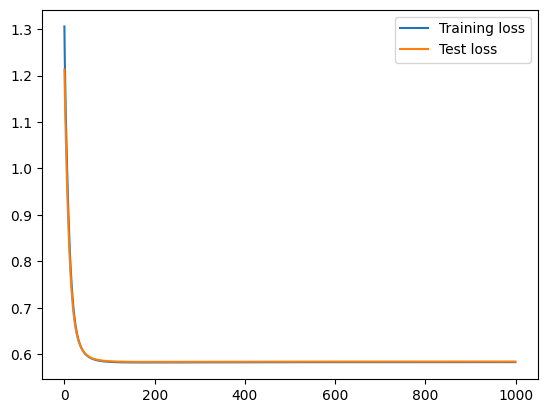

In [19]:
classifier.plot_losses()

In [20]:
p_train = classifier.predict(classifier.X_train)
training_accuracy = np.mean(p_train == classifier.y_train.numpy())
p_valid = classifier.predict(classifier.X_valid)
valid_accuracy = np.mean(p_valid == classifier.y_valid.numpy())
p_test = classifier.predict(classifier.features_test)
test_accuracy = np.mean(p_test == classifier.labels_test.numpy())
print(training_accuracy, valid_accuracy, test_accuracy)

0.7151058823529411 0.7026666666666667 0.71304


We get the same results as before, so we can be sure that the classifier is working correctly. Also, using PySpark is much faster than using Pandas.